### Train SVC image classifier for multiple categories
- font: https://www.geeksforgeeks.org/image-classification-using-support-vector-machine-svm-in-python/

In [ ]:
#### Filipe Carvalho Silva, 2024

import pandas as pd 
import os 
from skimage.transform import resize 
from skimage.io import imread 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import joblib

In [46]:
## Parameters

use_cifar10_images = False
datadir = 'images/train/'
model_name = 'models/svc_classifier_cifar10.pkl' if use_cifar10_images else 'models/svc_classifier_custom.pkl'

categories = ['airplane','car'] 
categories_codes = [0,1]
img_size = 32 # 150

In [47]:
def plot_img(images):
    for i in range(0,9):
        plt.subplot(330 + 1 + i)
        plt.imshow(images[i])
    plt.show()

In [48]:
def get_custom_training_images(datadir='images/train/'):
	## Use custom images for model training

	flat_data_arr=[] #input array # X_train
	target_arr=[] #output array # y_train
	#path which contains all the categories of images 
	for i in categories: 
		print(f'loading... category : {i}') 
		path=os.path.join(datadir,i) 
		for img in os.listdir(path): 
			img_array=imread(os.path.join(path,img))
			img_resized=resize(img_array,(img_size,img_size,3))
			flat_data_arr.append(img_resized.flatten()) 
			target_arr.append(categories.index(i)) 
		print(f'loaded category:{i} successfully') 
	flat_data=np.array(flat_data_arr) 
	target=np.array(target_arr)
	#dataframe 
	df=pd.DataFrame(flat_data) 
	df['Target']=target 
	return df

In [49]:
def get_cifar10_training_images():
    from keras.datasets import cifar10

    (trainX, trainy), (testX, testy) = cifar10.load_data()

    # Filter categories 0 and 1 for airplane and automobile
    subset_trainX = trainX[np.isin(trainy, categories_codes).flatten()]
    subset_trainy = trainy[np.isin(trainy, categories_codes).flatten()]
    
    # Shuffle images
    idx = np.arange(len(subset_trainX))
    np.random.shuffle(idx)

    # get first 1% of data
    subset_trainX = subset_trainX[:int(.01*len(idx))]
    subset_trainy = subset_trainy[:int(.01*len(idx))]

    plot_img(subset_trainX)

    flat_data_arr = []
    for img_resized in subset_trainX: 
        # img_resized=resize(img_array,(150,150,3)) 
        flat_data_arr.append(img_resized.flatten())
    flat_data=np.array(flat_data_arr)
    #dataframe 
    df=pd.DataFrame(flat_data) 
    df['Target']=subset_trainy 
    return df


In [50]:
df = get_cifar10_training_images() if use_cifar10_images else get_custom_training_images(datadir)
print(df.shape)
#input data 
x=df.iloc[:,:-1] 
#output data 
y=df.iloc[:,-1]

# Splitting the data into training and testing sets 
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20, random_state=77, stratify=y) 

loading... category : airplane
loaded category:airplane successfully
loading... category : car
loaded category:car successfully
(50, 3073)


In [51]:
# Defining the parameters grid for GridSearchCV 
param_grid={'C':[0.1,1,10,100], 
			'gamma':[0.0001,0.001,0.1,1], 
			'kernel':['rbf','poly']} 

# Creating a support vector classifier 
svc=svm.SVC(probability=True) 

# Creating a model using GridSearchCV with the parameters grid 
model=GridSearchCV(svc,param_grid)

In [52]:
# Training the model using the training data 
model.fit(x_train,y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['rbf', 'poly']})

In [53]:
# Testing the model using the testing data 
y_pred = model.predict(x_test) 

# Calculating the accuracy of the model 
accuracy = accuracy_score(y_pred, y_test) 

# Print the accuracy of the model 
print(f"The model is {accuracy*100}% accurate")

The model is 90.0% accurate


In [54]:
print(classification_report(y_test, y_pred, target_names=categories))

              precision    recall  f1-score   support

    airplane       0.83      1.00      0.91         5
         car       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



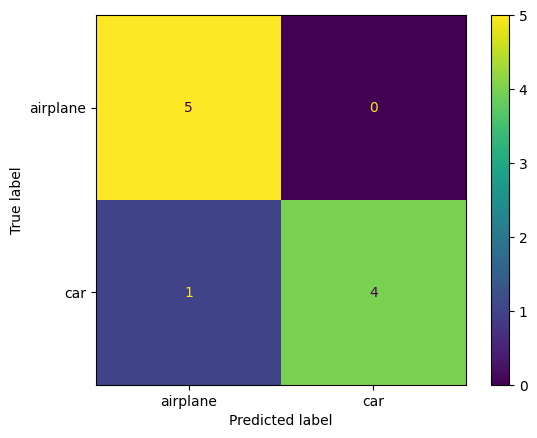

In [61]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = categories)
cm_display.plot()
plt.show()

In [28]:
joblib.dump(model, model_name)

['models/svc_classifier_custom.pkl']

In [44]:
pd.DataFrame(x_test.index).to_csv('images/train/test_images_indexes.csv', index=False)